In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100
import plotly.graph_objects as go
from scipy.optimize import fsolve
# import warnings
# warnings.filterwarnings("error")
import pyvista as pv

In [45]:
T = 3

a = 0
b = 1

h = 0.05
tau = 0.1

M = int(T/tau) + 1
N = int((b-a)/h) + 1

U = np.zeros((M, N))
Q = np.zeros(N)
Psi = np.ones(N-1)
Psis = [Psi.copy()]

Kuxt = lambda u, x, t: u**2
K = lambda m, n: Kuxt(U[m][n], n*h, m*tau)

for n in range(N):
    U[0][n] = 0#1 - n*h
    # U[0][n] = -40*((n*h)-0.5)**2+10
    # U[0][n] = 10*np.sin(10*n*h)

for m in range(1, M):
    def F(Q_m):
        F_retuned = np.zeros(N)
        F_retuned[0] = Q_m[0]
        for i in range(1, N-1):
            alpha = 0.06
            A = (0.5-alpha)*Q_m[i-1]+(0.5+alpha)*Q_m[i+1]+h/tau*((0.5-alpha)*Psi[i-1] - (0.5+alpha)*Psi[i])
            B = (0.5+alpha)*Q_m[i-1]+(0.5-alpha)*Q_m[i+1]+h/tau*((0.5+alpha)*Psi[i-1] - (0.5-alpha)*Psi[i])
            if np.abs(U[m-1][i+1] - U[m-1][i-1]) < 0.000001:
                if (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
                    K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
                    2/h/(Psi[i]+Psi[i-1]) * (U[m-1][i+1] - U[m-1][i-1]) < 0:
                    F_retuned[i] = Q_m[i] - A
                else:
                    F_retuned[i] = Q_m[i] - B
            else:
                Q_counted = (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
                        K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
                        2/h/(Psi[i]+Psi[i-1])/(U[m-1][i+1] - U[m-1][i-1])
                if Q_counted < Q_m[i+1] - h/tau*Psi[i]:
                    F_retuned[i] = A - Q_m[i]
                elif Q_counted > Q_m[i-1] + h/tau*Psi[i-1]:
                    F_retuned[i] = B - Q_m[i]
                else:
                    F_retuned[i] = Q_counted - Q_m[i]
        F_retuned[N-1] = Q_m[N-1]
        return F_retuned
    Q = fsolve(F, h*np.ones(N))
    # Q = (np.random.rand(N)-0.5)/10
    # Q = np.zeros(N)
    # Q = np.ones(N)*(-1)/15
    # Q[0] = 0
    # Q[-1] = 0

    # Q[0] = 0
    # for i in range(1, N - 1):
    #     # if np.abs(A[m-1][i+1] - A[m-1][i-1]) < 0.01 or np.abs(Psi[i]+Psi[i-1]) < 0.01:
    #     #     Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
    #     #             K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
    #     #             2/h/0.01/ 0.01
    #     # else:
    #     #     try:
    #     #         Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
    #     #                 K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
    #     #                 2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
    #     #     except:
    #     #         pass
    #     # if Psi[i-1] + tau/h*(Q[i-1]-Q[i]) < 0:
    #     #     Q[i] = h/tau*Psi[i-1]/2 + Q[i-1]
    #     # else:
    #     #     Q[i] += h/tau*Psi[i-1]/2 + Q[i-1]
    #     counted = (K(m-1, i+1)*(U[m-1][i+1] - U[m-1][i]) - \
    #                 K(m-1, i-1)*(U[m-1][i] - U[m-1][i-1])) * \
    #                 2/h/(Psi[i]+Psi[i-1])/(U[m-1][i+1] - U[m-1][i-1])
    #     right =  h/tau*np.min(Psi[:i])
    #     left = -h/tau*np.min(Psi[i:])
    #     if left < counted < right:
    #         Q[i] = counted
    #     elif counted > right:
    #         Q[i] = right/2
    #     elif counted < left:
    #         Q[i] = left/2
    #     # Q[i] = (left+right)/2
    #     # Q[i] = 0
    # Q[N-1] = 0

    Psi_next = np.ones(N-1)
    for i in range(0, N-1):
        Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
        
    def Equations(U_m):
        Equations_returned = np.zeros(N)
        Equations_returned[0] = U_m[0] - 1 
        Equations_returned[N-1] = U_m[N-1]
        for n in range(1, N-1):
            Equations_returned[n] = (tau/(2*h**2)*(K(m-1, n+1) + K(m-1, n))/Psi[n]) * U_m[n+1] -\
                                    ((Psi_next[n] + Psi_next[n-1])/2 +\
                                        tau/(2*h**2)*((K(m-1,n+1) + K(m-1, n))/Psi[n]+(K(m-1,n) + K(m-1, n-1))/Psi[n-1]))*U_m[n] +\
                                    (tau/(2*h**2)*(K(m-1, n) + K(m-1, n-1))/Psi[n-1]) * U_m[n-1] -\
                                    tau/h*(Q[n+1]*U[m-1][n+1] - Q[n]*U[m-1][n]) +\
                                    (Psi[n]+Psi[n-1])/2*U[m-1][n]
        return Equations_returned
                    
            
    # A = np.zeros((N, N))
    # B = np.zeros(N)
    # for n in range(0, N):
    #     if n == 0:
    #         A[n][0] = 1
    #         B[n] = 1
    #     elif n == N-1:
    #         A[n][N-1] = 1
    #         B[n] = 0
    #     else:
    #         # Psi_nM1 = (Psi[n-2] + Psi[n-1])/2
    #         Psi_n = (Psi[n-1] + Psi[n])/2
    #         # Psi_nP1 = Psi[n] if n == N-2 else (Psi[n] + Psi[n+1])/2
    #         Psi_n_next = (Psi_next[n-1] + Psi_next[n])/2
    #         # A[n][n-1] = tau/2/h**2*(K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1)
    #         # A[n][n] = -(Psi_n_next+tau/2/h**2*(K(m-1, n+1)/Psi_nP1+2*K(m-1, n)/Psi_n+K(m-1, n-1)/Psi_nM1))
    #         # A[n][n+1] = tau/2/h**2*(K(m-1, n+1)/Psi_nP1+K(m-1, n)/Psi_n)
    #         # B[n] = tau/h*(Q[n+1]*U[m-1][n+1]-Q[n]*U[m-1][n])-Psi_n*U[m-1][n]
    #         A[n][n-1] = tau/2/h**2*((K(m-1, n-1)+K(m-1, n))/Psi[n-1])
    #         A[n][n] = -(Psi_n_next+tau/2/h**2*((K(m-1, n+1)+K(m-1, n))/Psi[n]+(K(m-1, n)+K(m-1, n-1))/Psi[n-1]))
    #         A[n][n+1] = tau/2/h**2*((K(m-1, n)+K(m-1, n+1))/Psi[n])
    #         B[n] = tau/h*(Q[n+1]*U[m-1][n+1]-Q[n]*U[m-1][n])-Psi_n*U[m-1][n]

    # # X = np.linalg.inv(A).dot(B)
    # X = np.linalg.solve(A, B)
    # U[m] = X
    U[m] = fsolve(Equations, U[m-1])

    Psi = Psi_next.copy()
    
    Psis.append(Psi.copy())

c:\Users\stas2\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

c:\Users\stas2\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



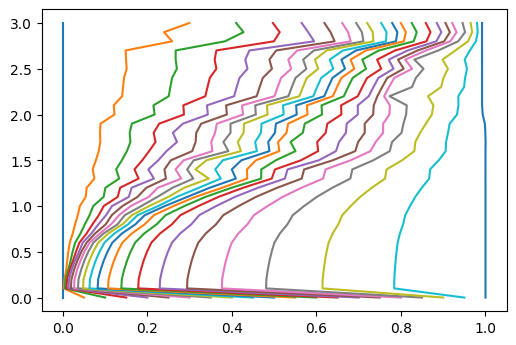

In [46]:
t = 0
graph = []
for i, Psi in enumerate(Psis):
    if i % 1 == 0:
        X = list()
        xi = 0
        X.append(xi)
        for psi in Psi:
            xi += psi * h
            X.append(xi)
        graph.append([X, list(np.full((len(X)), t))])
        # plt.scatter(X, np.full((len(X)), t), s=1, color='black')
        t += tau
graph = np.array(graph)
graph = graph.transpose()
# graph.shape, graph[0]
for l in graph:
    # l = line.transpose()
    plt.plot(l[0], l[1])
plt.show()

In [47]:
def make_point_set():
    t = 0
    points = np.zeros((M*N, 3))
    for i, Psi in enumerate(Psis):
        points[i*N:(i+1)*N, 2] = U[i, :]
        if i % 1 == 0:
            X = np.zeros((N))
            for j, psi in enumerate(Psi, 1):
                X[j] = X[j-1] + psi * h
            points[i*N:(i+1)*N, 0] = X
            points[i*N:(i+1)*N, 1] = np.full((N), t)
            # points[i*N:(i+1)*N, :2] = np.array([X, np.full((N), t)]).transpose()
            # plt.scatter(X, np.full((len(X)), t), s=1, color='black')
            t += tau
    foo = pv.PolyData(points)
    foo.rotate_z(0, inplace=True)
    return foo.points
# def make_point_set_example():
#     """Ignore the contents of this function. Just know that it returns an
#     n by 3 numpy array of structured coordinates."""
#     n, m = 29, 32
#     x = np.linspace(-200, 200, num=n) + np.random.uniform(-5, 5, size=n)
#     y = np.linspace(-200, 200, num=m) + np.random.uniform(-5, 5, size=m)
#     xx, yy = np.meshgrid(x, y)
#     A, b = 100, 100
#     zz = A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
#     points = np.c_[xx.reshape(-1), yy.reshape(-1), zz.reshape(-1)]
#     foo = pv.PolyData(points)
#     foo.rotate_z(36.6, inplace=True)
#     return foo.points


# poly_data = pv.PolyData(points)
mesh = pv.StructuredGrid()
# Set the coordinates from the numpy array
mesh.points = make_point_set()
# set the dimensions
mesh.dimensions = [N, M, 1]
# mesh.plot()
mesh.plot(show_edges=True, show_grid=True)
# mesh.plot(show_edges=True, show_grid=True, cpos="xy")

# plt.figure(figsize=(10, 10))
# plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], s=1)
# plt.axis("image")
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [43]:
N = 10
f = lambda x : 1
v = lambda x : 5*np.sin(10*x)
k = lambda x : 1
a = 0
b = 1

def Func(UX):
    F_retuned = np.zeros(2*N + 1)
    F_retuned[0] = UX[0]
    F_retuned[N-1] = UX[N-1]
    F_retuned[N + N] = UX[N] - a
    F_retuned[N + N - 1] = UX[N + N - 1] - b
    d = 0
    for i in range(1, N):
        d += np.sqrt((UX[N+i] - UX[N+i-1])**2 + (UX[i] - UX[i-1])**2)
    d *= (N - 1)
    for i in range(1, N-1):
            h_i = UX[N + i] - UX[N + i - 1]
            h_i_next = UX[N + i + 1] - UX[N + i]
            F_retuned[i] = 2/(UX[N + i + 1] - UX[N + i - 1])*((UX[i+1] - UX[i])/h_i_next - (UX[i]-UX[i-1])/h_i) + v(UX[N + i])*(UX[i+1] - U[i])/h_i_next - f(UX[N+i])
    return F_retuned
    for i in range(0, N-1):
        F_retuned[N + i] = (UX[N+i+1] - UX[N+i])**2 + (UX[i+1] - UX[i])**2 - d**2

U = np.zeros(N)
X = np.linspace(a, b, N)
UX_0 = np.concatenate((U, X))
UXd_0 = np.concatenate((UX_0, [1]))
UX = fsolve(Func, UXd_0)

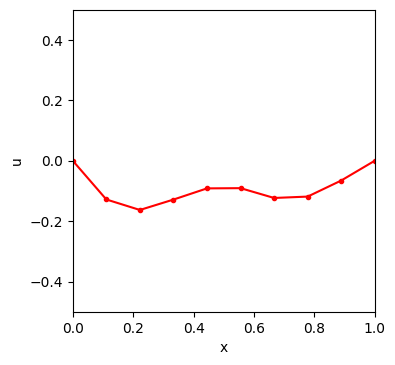

In [44]:
# UX[N:2*N]
# plt.scatter(x=UX[N:2*N], y=UX[:N], s=2)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(UX[N:2*N], UX[:N], '.r-')
plt.xlim(0, 1)
plt.ylim(-0.5, 0.5)
ax.set_aspect('equal', adjustable='box')

plt.xlabel("x")
plt.ylabel("u")

plt.show()


In [11]:
sh_0, sh_1 = U.shape
fig = go.Figure()
fig.add_surface(
    # contours = {
    #     "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
    #     "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    # },
    x = np.linspace(a, b, sh_1),
    y = np.linspace(0, T, sh_0),
    z = U
    )
# fig.add_scatter3d(name='scat_p', x=np.linspace(a, b, sh_1), y=np.linspace(0, T, sh_0), z=U, mode='markers',
#     marker=dict(size=10, color='black',colorscale='Reds'))
# fig.update_layout(
#         scene = {
#             "xaxis": {"nticks": 20},
#             "zaxis": {"nticks": 4},
#             'camera_eye': {"x": 0, "y": -1, "z": 0.5},
#             "aspectratio": {"x": 1, "y": 1, "z": 0.2}
#         })
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=5, r=50, b=5, t=55))
fig.show()

In [26]:
N = 10
f = lambda x : 0
v = lambda x : sin(10*x)
k = lambda x : 1
a = 0
b = 1 

def Func(UX):
        F_retuned = np.zeros(2*N)
        F_retuned[0] = UX[0]
        F_retuned[N-1] = UX[N-1]
        F_retuned[N] = UX[N] - a
        F_retuned[N + N - 1] = UX[N + N - 1] - b
        d = 0
        for i in range(0, N):
                d += (UX[N + i + 1] - UX[N + i])*np.sqrt(1 + ((UX[i+1] - UX[i])/(UX[N + i + 1] - UX[N + i]))**2)
        d /= (N - 1)
        for i in range(1, N-1):
                h_i = UX[N + i] - UX[N + i - 1]
                h_i_next = UX[N + i + 1] - UX[N + i]
                F_retuned[i] = 1/h_i*((UX[i+1] - UX[i])/h_i_next - (UX[i]-UX[i-1])/h_i) + v(UX[N + i])*(UX[i+1] - U[i])/h_i_next - f(UX[N+i])
                F_retuned[N + i] = (UX[N+i+1] - UX[N+i])**2 + (UX[i+1] - UX[i])**2 - h**2
        return F_retuned
U = np.zeros(N)
X = np.linspace(a, b, N)
UX_0 = np.concatenate((U, X))
UX = fsolve(Func, UX_0)
        

IndexError: index 20 is out of bounds for axis 0 with size 20